┌ Info: CORRECT σ-form: n=5  edge≈3.1622776601683795; domain [-0.3377223398316205,6.66227766016838]; Nquad=220; anchors=61
└ @ Main /Users/guhaonan/Desktop/MIT/random matrix theory research/painleve iv new anchor method/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:164
┌ Info:   anchor 5/61 at s0=6.196
└ @ Main /Users/guhaonan/Desktop/MIT/random matrix theory research/painleve iv new anchor method/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:177
┌ Info:   anchor 10/61 at s0=5.612
└ @ Main /Users/guhaonan/Desktop/MIT/random matrix theory research/painleve iv new anchor method/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:177
┌ Info:   anchor 15/61 at s0=5.029
└ @ Main /Users/guhaonan/Desktop/MIT/random matrix theory research/painleve iv new anchor method/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:177
┌ Info:   anchor 20/61 at s0=4.446
└ @ Main /Users/guhaonan/Desktop/MIT/random matrix theory research/painlev

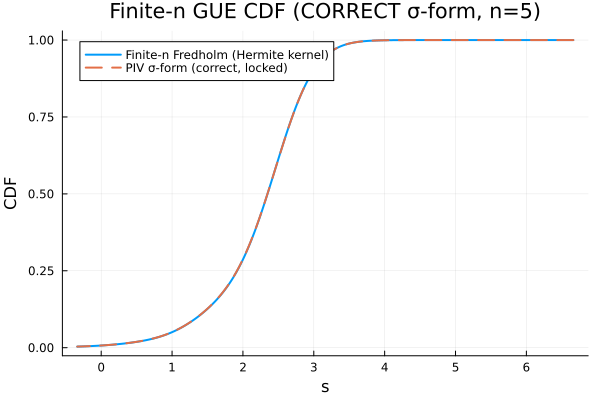

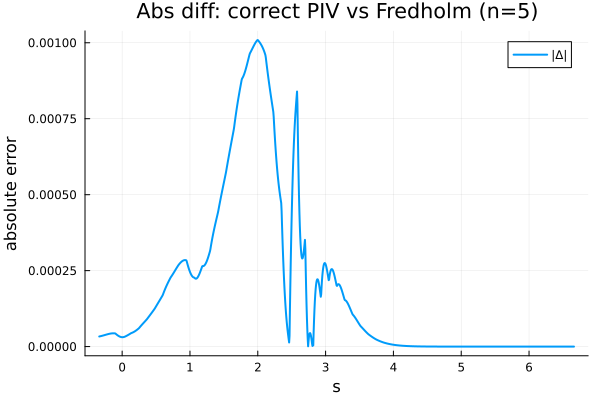

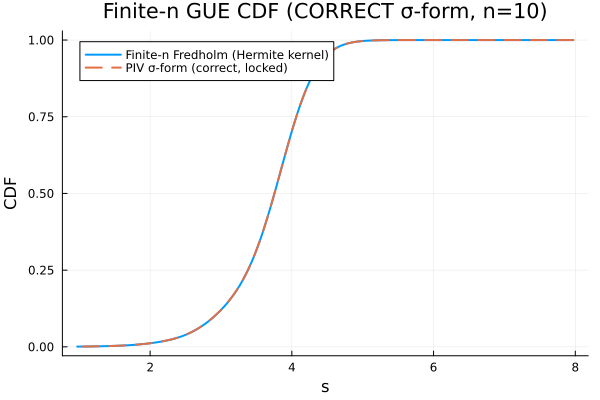

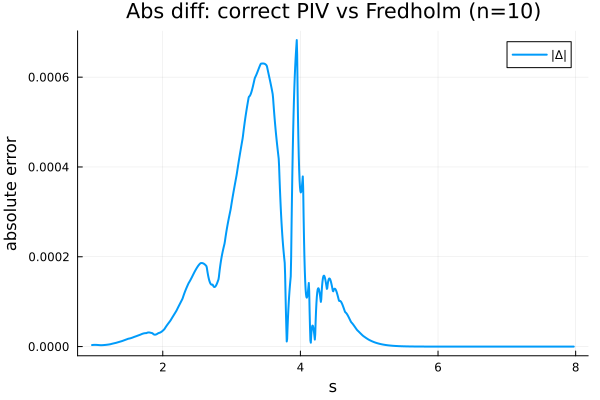

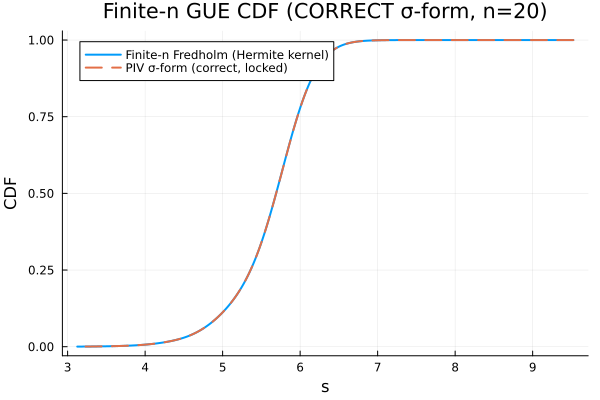

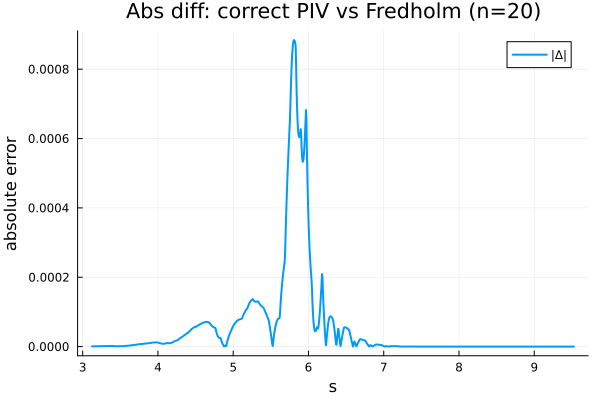

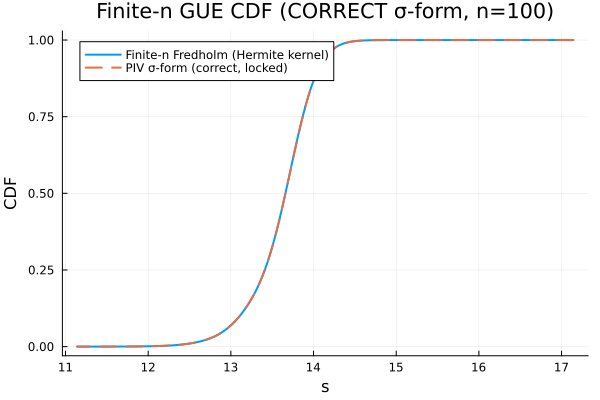

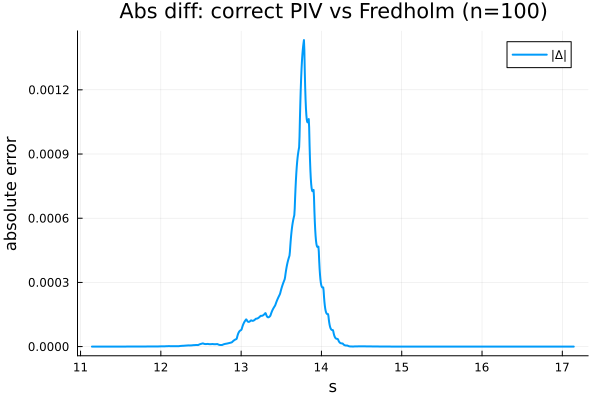

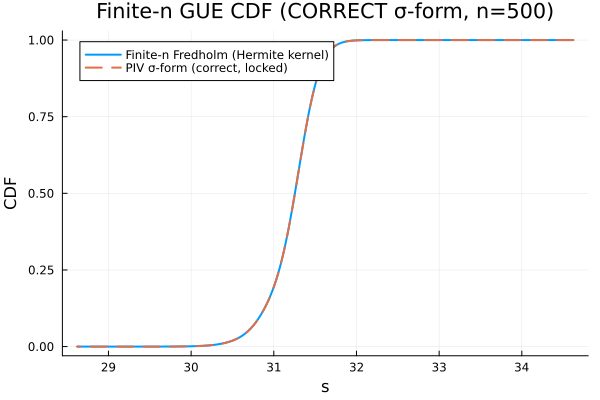

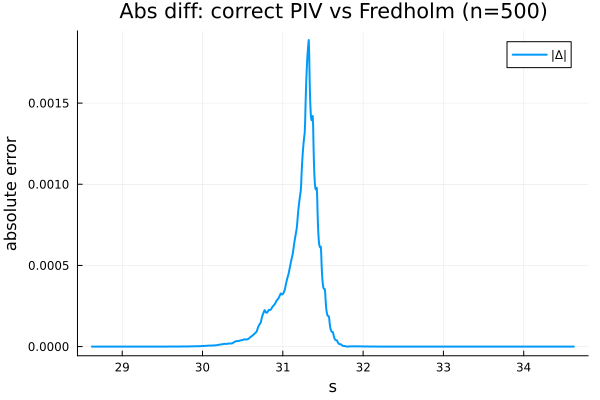

In [4]:
# finite_n_piv_locked_correct_sigma
#
#   (σ'')^2 = 4 (s σ' - σ)^2 - 4 (σ')^2 (σ' + 2n)
#
# Correct Painlevé IV σ-form with branch-locked integration
# for comparison experiments.

import Pkg
for p in ["OrdinaryDiffEq","FastGaussQuadrature","LinearAlgebra","Statistics","Plots"]
    Base.find_package(p) === nothing && (try Pkg.add(p) catch; Pkg.Registry.update(); Pkg.add(p); end)
end

using OrdinaryDiffEq, FastGaussQuadrature, LinearAlgebra, Statistics, Plots
gr()

# ---------------------------
# Orthonormal Hermite functions (weight e^{-x^2/2})
# ---------------------------
function hermite_phi_chain(n::Int, x::Float64)
    # returns (φ_{n-1}(x), φ_n(x), sum_{k=0}^{n-1} φ_k(x)^2)
    ϕ0 = pi^(-0.25) * exp(-0.5*x*x)
    if n == 1
        return (ϕ0, sqrt(2.0)*x*ϕ0, ϕ0^2)
    end
    ϕ1 = sqrt(2.0)*x*ϕ0
    sumsq = ϕ0^2
    if n == 2
        sumsq += ϕ1^2
        return (ϕ1, sqrt(1.0)*x*ϕ1 - 1.0*ϕ0, sumsq)
    end
    ϕkm1, ϕk = ϕ0, ϕ1
    sumsq += ϕ1^2
    for k in 1:(n-2)
        α = sqrt(2.0/(k+1))
        β = sqrt(k/(k+1))
        ϕkp1 = α*x*ϕk - β*ϕkm1
        ϕkm1, ϕk = ϕk, ϕkp1
        sumsq += ϕk^2
    end
    α = sqrt(2.0/n)
    β = sqrt((n-1)/n)
    ϕn = α*x*ϕk - β*ϕkm1
    return (ϕk, ϕn, sumsq)
end

# Christoffel–Darboux Hermite kernel with diagonal fallback
function K_hermite(n::Int, s::Float64, t::Float64)
    if s == t
        _, _, sumsq = hermite_phi_chain(n, s)
        return sumsq
    end
    φnm1_s, φn_s, _ = hermite_phi_chain(n, s)
    φnm1_t, φn_t, _ = hermite_phi_chain(n, t)
    return sqrt(n/2) * (φnm1_s*φn_t - φn_s*φnm1_t) / (s - t)
end

# ---------------------------
# Fredholm determinant via Nyström on [s, s+L(n)]
# ---------------------------
tail_len(n::Int) = n ≤ 50 ? 8.0 : (n ≤ 500 ? 10.0 : 12.0)

function F_n_fredholm(n::Int, s::Float64; N::Int=240, L::Float64=tail_len(n))
    z, w = gausslegendre(N)
    u  = (z .+ 1.0) .* (L/2)
    dt = (L/2) .* w
    t  = s .+ u
    sq = sqrt.(dt)
    A  = Matrix{Float64}(undef, N, N)
    @inbounds for j in 1:N
        tj = t[j]
        for i in 1:N
            A[i,j] = sq[i] * K_hermite(n, t[i], tj) * sq[j]
        end
    end
    λ = eigvals(Matrix(I - A))
    λ = clamp.(real.(λ), eps(), 1.0)
    return exp(sum(log, λ))
end

F_n_vec(n::Int, svals::AbstractVector{<:Real}; N::Int=240, L::Float64=tail_len(n)) =
    [F_n_fredholm(n, Float64(s); N=N, L=L) for s in svals]

# ---------------------------
# σ, σ', σ'' from local LS fit of log F (degree-4 poly)
# ---------------------------
function sigma_from_logF(spts::Vector{Float64}, Fvals::Vector{Float64})
    s0 = spts[cld(length(spts),2)]
    u  = spts .- s0
    y  = log.(Fvals)
    M  = hcat(u.^0, u, u.^2, u.^3, u.^4)
    c  = M \ y
    σ    = c[2]
    σp   = 2c[3]
    σpp0 = 6c[4]
    F0   = exp(c[1])
    return (; s0, σ, σp, σpp0, F0)
end

# ---------------------------
# Correct PIV σ-form and stepping with branch tracking
#
#   (σ'')^2 = 4 (s σ' - σ)^2 - 4 (σ')^2 (σ' + 2n)
# ---------------------------
@inline function piv_rhs(s::Float64, σp::Float64, σ::Float64, n::Int)
    return 4.0*(s*σp - σ)^2 - 4.0*(σp^2)*(σp + 2.0*n)
end

@inline function choose_sigma_pp(prev_σpp::Float64, s::Float64,
                                 σ::Float64, σp::Float64, n::Int)
    rhs = piv_rhs(s, σp, σ, n)
    rhs ≤ 0 && return 0.0
    r = sqrt(rhs)

    # If we don't yet have a reliable sign, start with +√rhs
    if abs(prev_σpp) < 1e-10
        return r
    end

    c1 =  sign(prev_σpp) * r
    c2 = -sign(prev_σpp) * r
    return abs(c1 - prev_σpp) ≤ abs(c2 - prev_σpp) ? c1 : c2
end

function step_sigma!(σ::Float64, σp::Float64,
                     s_now::Float64, s_next::Float64,
                     n::Int, prev_σpp::Float64)
    h = s_next - s_now
    σpp = choose_sigma_pp(prev_σpp, s_now, σ, σp, n)
    σ_new  = σ  + h*σp + 0.5*h^2*σpp
    σp_mid = σp + 0.5*h*σpp
    σpp2   = choose_sigma_pp(σpp, 0.5*(s_now+s_next), σ_new, σp_mid, n)
    σp_new = σp + h*σpp2
    return σ_new, σp_new, σpp2
end

# ---------------------------
# Reconstruct CDF from σ via trapezoid rule
# ---------------------------
function F_from_sigma_grid(sgrid::Vector{Float64}, σvals::Vector{Float64},
                           s0::Float64, F0::Float64)
    n = length(sgrid)
    logF = zeros(n)
    k0   = findmin(abs.(sgrid .- s0))[2]
    logF[k0] = log(F0)
    for k in (k0-1):-1:1
        dx = sgrid[k+1] - sgrid[k]
        logF[k] = logF[k+1] + 0.5*(σvals[k] + σvals[k+1])*dx
    end
    for k in (k0+1):n
        dx = sgrid[k] - sgrid[k-1]
        logF[k] = logF[k-1] + 0.5*(σvals[k] + σvals[k-1])*dx
    end
    return exp.(logF)
end

# ---------------------------
# One full run (CORRECT PIV, robust Nyström)
# ---------------------------
function finite_n_piv_locked_correct(; n::Int=20, window_half::Float64=3.0,
                                     NquadFD::Int=260, npts::Int=1201, nanchors::Int=81)

    s_edge = sqrt(2.0*n)
    smin, smax = s_edge - window_half, s_edge + window_half
    @info "CORRECT σ-form: n=$n  edge≈$s_edge; domain [$smin,$smax]; Nquad=$NquadFD; anchors=$nanchors"

    sgrid = collect(range(smax, smin; length=npts))

    anchors = collect(range(smax, smin; length=nanchors))
    h_anc   = (anchors[end]-anchors[1])/(length(anchors)-1)
    stencil = (-3:3) .* (0.5*h_anc)

    anc = Vector{NamedTuple}(undef, length(anchors))
    for (j, s0) in pairs(anchors)
        spts = Float64[s0 + δ for δ in stencil]
        Fpts = F_n_vec(n, spts; N=NquadFD)
        anc[j] = sigma_from_logF(spts, Fpts)
        (j % 5 == 0) && @info "  anchor $j/$(length(anchors)) at s0=$(round(s0,digits=3))"
    end

    σvals  = similar(sgrid)
    σpvals = similar(sgrid)

    σvals[1]  = anc[1].σ
    σpvals[1] = anc[1].σp
    σpp_local = anc[1].σpp0
    k = 1

    for j in 1:(length(anchors)-1)
        sR = anchors[j+1]
        while k < length(sgrid) && sgrid[k] > sR + 1e-12
            σvals[k+1], σpvals[k+1], σpp_local =
                step_sigma!(σvals[k], σpvals[k], sgrid[k], sgrid[k+1], n, σpp_local)
            k += 1
        end
        idx = findmin(abs.(sgrid .- sR))[2]
        σvals[idx]  = anc[j+1].σ
        σpvals[idx] = anc[j+1].σp
        σpp_local   = anc[j+1].σpp0
        k = idx
    end

    F_piv = F_from_sigma_grid(sgrid, σvals, anc[1].s0, anc[1].F0)
    F_fd  = F_n_vec(n, sgrid; N=max(NquadFD,280))

    plt1 = plot(sgrid, F_fd, lw=2, label="Finite-n Fredholm (Hermite kernel)",
                xlabel="s", ylabel="CDF",
                title="Finite-n GUE CDF (CORRECT σ-form, n=$(n))")
    plot!(plt1, sgrid, F_piv, lw=2, ls=:dash, label="PIV σ-form (correct, locked)")
    savefig(plt1, "finite_n_piv_correct_vs_fd_n$(n).png"); display(plt1)

    plt2 = plot(sgrid, abs.(F_fd .- F_piv), lw=2, label="|Δ|",
                xlabel="s", ylabel="absolute error",
                title="Abs diff: correct PIV vs Fredholm (n=$(n))")
    savefig(plt2, "finite_n_piv_correct_absdiff_n$(n).png"); display(plt2)

    @info "CORRECT σ-form: n=$n: max |Δ| = $(maximum(abs.(F_fd .- F_piv)))"
    return (sgrid=sgrid, F_fd=F_fd, F_piv=F_piv, plt1=plt1, plt2=plt2)
end

# ---------------------------
# Run the suite (CORRECT σ-form)
# ---------------------------
function run_suite()
    configs = [
        (n=5,    N=220, anchors=61,  window=3.5),
        (n=10,   N=240, anchors=81,  window=3.5),
        (n=20,   N=260, anchors=91,  window=3.2),
        (n=100,  N=280, anchors=101, window=3.0),
        (n=500,  N=300, anchors=121, window=3.0),
    ]
    for c in configs
        finite_n_piv_locked_correct(n=c.n, NquadFD=c.N,
                                    nanchors=c.anchors, window_half=c.window)
    end
    @info "CORRECT σ-form: saved all figures in $(pwd())"
end

run_suite()


┌ Info: CORRECT σ-form: n=1000  edge≈44.721359549995796; domain [41.721359549995796,47.721359549995796]; Nquad=320; anchors=131
└ @ Main /Users/guhaonan/Desktop/MIT/random matrix theory research/painleve iv new anchor method/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:164
┌ Info:   anchor 5/131 at s0=47.537
└ @ Main /Users/guhaonan/Desktop/MIT/random matrix theory research/painleve iv new anchor method/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:177
┌ Info:   anchor 10/131 at s0=47.306
└ @ Main /Users/guhaonan/Desktop/MIT/random matrix theory research/painleve iv new anchor method/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:177
┌ Info:   anchor 15/131 at s0=47.075
└ @ Main /Users/guhaonan/Desktop/MIT/random matrix theory research/painleve iv new anchor method/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W0sZmlsZQ==.jl:177
┌ Info:   anchor 20/131 at s0=46.844
└ @ Main /Users/guhaonan/Desktop/MIT/random matrix theory res

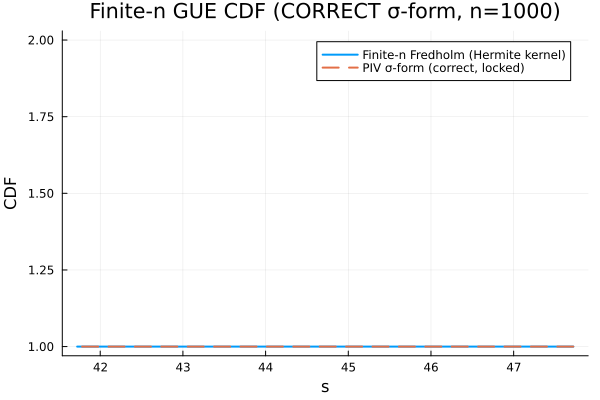

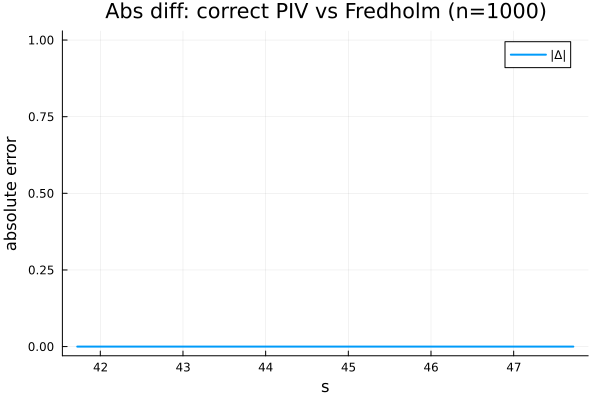

In [5]:
function run_suite1000()
    configs = [
        (n=1000, N=320, anchors=131, window=3.0),  # <- new line
    ]
    for c in configs
        finite_n_piv_locked_correct(
            n          = c.n,
            NquadFD    = c.N,
            nanchors   = c.anchors,
            window_half = c.window,
        )
    end
    @info "CORRECT σ-form: saved all figures in $(pwd())"
end

run_suite1000()
